## Logicle Scale
The implementation of the Logicle scale is based on the paper [[1]](#1) and its update from 2012.
Before we do the estimation, we first implement the logicle transformation and its gradient as functions. And also their inverse functions.

From the paper [[1]](#1) we get the following representation of the scaleing function
$$ S(X;W)=\begin{cases}
T*10^{-(M-W-A)}\left(10^{X-W-A}-p^2*10^{-(X-W-A)/p}+p^2-1\right), & X\geq W+A\\
-T*10^{-(M-W-A)}\left(10^{X-W-A}-p^2*10^{-(X-W-A)/p}+p^2-1\right), & X<W+A
\end{cases} $$ 
with $ W=2p\log(p)/(p+1) $ and all parameters are in log10 units. 
The standard values are $A=0, W=0.5, M=4.5, T=1000$.

The interpretation of the parameter is the following:
T: Top of the scale
W: Linearization width (range of linearization around zero) 
A: Number of decades in the negative range
M: Width of the display in decades 

The practical implementation follows the updated version of the original paper [[2]](#2) and is to a scale range of $[0,1]$.
It takes the biexponential function 
$$ B(x; a,b,c,d,f)=ae^{bx}-ce^{-dx}+f $$
with the condition for the data zero position $x_1$
$$ \frac{d^2B(x)}{dx^2}|_{x=x_1}=0\quad\text{ and }\quad B(x_1)=0.
$$ 


### Parameters
In a first part we compute the actual parameters $b$ and $w$ from the formal parameters $W, M$ and $A$

In [1]:
import numpy as np
import sys
import scipy
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [2]:
# set formal parameters
W = 0.5
A = -W # for data zero point to be zero use A=-W as rcommended in the paper (standard logicle would be A=0)
M = 9.12647141
# M = 5.126
T = 1000

# check parameter conditions
if T <= 0:
	sys.exit("T is not positive")

if W < 0:
	sys.exit("W is negative")

if M <= 0:
	sys.exit("M is not positive")

if 2 * W > M:
	sys.exit("W is too large")

if -A > W or A + W > M - W:
	sys.exit("A is too large")


# compute b and w from paper
b = (M+A)*np.log(10)
w = W/(M+A)

$w$ controls the range of data values in the quasilinear region. Next step is to compute the points marking the lower end, midpoint  and upper end of the quasilinear region.

In [3]:
x2 = A/(M+A)
x1 = x2 + w
x0 = x1 + w

The parameter $d$ can be obtained by solving $w=2\frac{ln(b)-ln(d)}{b+d}$. Since there is no closed form, this is solved numerically by finding the root of the function $g(d;b,w)=w(b+d)+2(ln(d)-ln(b))$.

In [4]:



def solve_d (w,b):
    if w==0:
        return b
    def g(x):
        g = w*(b+x)+2*(np.log(x)-np.log(b))
        return g
    d = fsolve(g, b)
    return d
    

d = solve_d(w,b)

Now we can compute the still missing parameters with the formulas from the paper [[2]](#2).

In [5]:
c_a = np.exp(x0*(b+d))
mf_a = np.exp(b*x1)- (c_a/np.exp(d*x1))

a = T / ((np.exp(b) - mf_a) - (c_a / np.exp(d)))
c = c_a * a 
f = -mf_a * a 


Before starting to implement the function, we comment a bit on the mathematics and the following implementation.
Note that we gave a biexponential function above, but the title is logicle scale. This is, because the logicle function will be the inverse of the above biexponential function. 
So in order to scale a parameter to the logicle scale, we need to implement the inverse of the above function. The inverse cannot be given in a closed form, so we need to solve it numerically.


The Logicle function as implemented below and proposed by the paper [[2]](#2) will scale a parameter space to the interval $[0,1]$, where the $0$ of the original scale will be mapped onto the reference value $x_1$ in the logicle scale, which corresponds to the condition $B(x_1)=0$.
In a neighborhood of this $x_1$, we cannot evaluate the biexponential function straightforward, since this would lose significance by subtracting terms that are nearly equal. So we will use a Taylor series approximation.

To compute the inverse numerically, we first give a good guess as follows. Given an arbitrary data value $y$, we guess that it is in the approximately logarithmic part if $y\geq f$. Hence, we can use $x=\ln(y)$ as a good approximation.
For $y<f$ it is in the linear part and we use the linear approximation $x=x_1+\frac{y}{B'(x_1)}$ as an initial estimate (This includes negative values sicne we use symmetry around $x_1$ to change a negative $y$ to a positive one and reflect the resulting x later at $x_1$).

With this guess we use Halley's method to get the root of the function $f(x)=B(x)-y$. The $x$ solving $f(x)=0$ is then the parameter value on the logicle scale. 

Halley's method uses as an iteration step 
$$ x_{n+1}=x_n-\Delta, \quad\text{with}\quad \Delta=\frac{f(x)}{f'(x)-\frac{f(x)}{f'(x)}\frac{f''(x)}{2}} $$

The linear part is then symmetrically around that value $x_1$ and for higher values it evolves a logarithmic behaviour. 

In [6]:
# Taylor series around x1 for value on logicle scale [0,1]
# We start the series with thefirst derivative, since the function value at x1 is 0 (logicle condition)

def biexponentialTaylorSeries(scaled):
    order = 16 # order of taylor series is 16

    posCoef = a*np.exp(b*x1)
    negCoef = -c*np.exp(-d*x1)
    taylorCoef = np.zeros(order)

    for i in range(order):
        posCoef = posCoef*(b/(i+1))
        negCoef = negCoef*(-d/(i+1))
        taylorCoef[i] = posCoef + negCoef
    taylorCoef[1]=0 # ensuring that the second derivative is 0 (logicle condition)    

    x = scaled - x1
    sum = 0

    for i in range(order): 
        sum = (sum + taylorCoef[order-1-i])*x 
        
    return sum


In [7]:
# implement the logicle transformation function

def logicleTransform1d(value):
    if value==0: # exclude exact zero value
        return x1

    negative = value<0
    if negative:
        value = -value
    
    if value < f:
        x = x1+(value/(a*b*np.exp(b*x1)+c*d*np.exp(-d*x1))) # later use taylorCoef[0] if functions are inside each other or a class
    
    if value >= f:
        x = np.log(value/a)/b # in original implementation other condition, why?
    
    tolerance = 1e-15 # set tolerance for convergence
    n_steps = 50 # set maximal number of steps for Halley's method
    taylor_treshold = x1 + w/4 # threshold for neighbourhood of x1 in which we apply taylor series (include in logicle object?)

    for i in range(n_steps):
        step = i
        first_term = a*np.exp(b*x)
        second_term = c*np.exp(-d*x)

        if x < taylor_treshold:
            y = biexponentialTaylorSeries(x) - value
        else:
            y = first_term-second_term+f - value
        dy = b*first_term + d*second_term
        ddy = b*b*first_term - d*d*second_term

        delta = y/(dy-((y*ddy)/(2*dy)))
        x = x - delta

        if np.absolute(delta) < tolerance:
            if negative:
                return 2*x1-x
            else:
                return x
                
    sys.exit("Scale did not converge!")
   
def logicleTransform(par):
    if np.ndim(par)==0:
        logicle_par = logicleTransform1d(par)
    else:
        length = len(par)
        logicle_par = np.zeros(length)

        for i in range(length):
            logicle_par[i] = logicleTransform1d(par[i])
    
    return logicle_par
    

    

In [8]:
# plotting the logicle function

par = np.linspace(0,1e3,10**5)

logicle_par = logicleTransform(par) 


In [9]:
logicleTransform1d(0.01)

array([0.42033999])

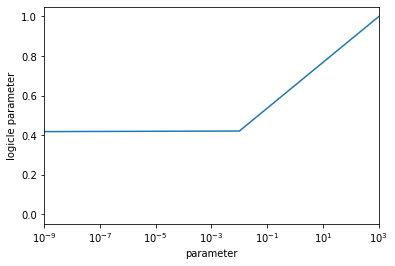

In [10]:

plt.plot(par, logicle_par)
plt.xlabel("parameter")
plt.ylabel("logicle parameter")
plt.xscale('log')
plt.xlim(1e-9,1e3)
plt.show()

Now we define the inverse transformation which is jsut the biexponential function from above. Again for values around $x_1$ we evaluate it using Taylor series.

In [11]:
def logicleInverseTransform(scaled):
    negative = scaled < x1

    if negative:
        scaled = 2*x1-scaled   # reflect negative region
    
    taylor_treshold = x1 + w/4 # threshold for neighbourhood of x1 in which we apply taylor series (include in logicle object?)

    if scaled < taylor_treshold:
        inverse = biexponentialTaylorSeries(scaled)
    else:
        inverse = a*np.exp(b*scaled)-c*np.exp(-d*scaled)+f

    if negative:
        return - inverse
    else:
        return inverse
    

In [12]:
# testing function and inverse

logicleTransform(1)
# logicleTransform(logicleInverseTransform((0.1)))

array([0.65223274])

In [13]:
# plotting logicle function with transition point 
par = np.linspace(0,1e3,10**5)

logicle_par = logicleTransform(par) 

# getting the transition point

transition_point = x0
transition = logicleInverseTransform(transition_point)

print(transition)



[1.00000085e-05]


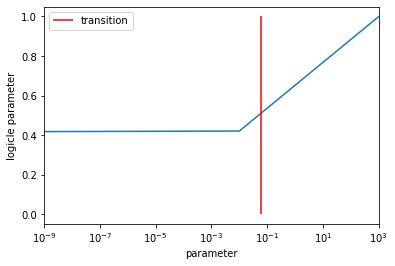

In [14]:
plt.plot(par, logicle_par)
plt.vlines(x0, 0, 1, color='red', label='transition')
plt.xlabel("parameter")
plt.ylabel("logicle parameter")
plt.xscale('log')
plt.xlim(1e-9,1e3)
plt.legend()
plt.show()

### References
<a id="1">[1]</a>
Parks, David; Roederer, Mario; Moore, Wayne (2006).
A new Logicle Display Method Avoids Deceptice Effects of Logarithmic Scaling for Low Signals and Compensated Data.
Article.
International Society for Analytical Cytology.

<a id="1">[2]</a>
Moore, Wayne (2012).
Update for the Logicle Data Scale Including Operational Code Implementations.
Article.
International Society for Advancement of Cytometry.



My first attempt to implement the logicle function, was to use \textit{fsolve} for the root finding in the inverting process. This gives nearly the same values for high values and still similar ones for low values. 
Since it does not give exactly 1 for 1000 as an input, as it should by our specified parameters, I used an implementation of Halley's method as proposed in [[2]](#2).